In [ ]:
#| hide

# This cell will not be rendered but is to hide warnings and limit the rows shown

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# Holt Model

> Step-by-step guide on using the `Holt Model` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

## Table of Contents

* [Introduction](#introduction)
* [Holt Model](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of Holt with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction<a class="anchor" id="introduction"></a>

The Holts model, also known as the double exponential smoothing method, is a forecasting technique widely used in time series analysis. It was developed by Charles Holt in 1957 as an improvement on Brown's simple exponential smoothing method.

The Holts model is used to predict future values of a time series that exhibits a trend. The model uses two smoothing parameters, one for estimating the trend and the other for estimating the level or base level of the time series. These parameters are called $\alpha$ and $\beta$, respectively.

The Holts model is an extension of Brown's simple exponential smoothing method, which uses only one smoothing parameter to estimate the trend and base level of the time series. The Holts model improves the accuracy of the forecasts by adding a second smoothing parameter for the trend.

One of the main advantages of the Holts model is that it is easy to implement and does not require a large amount of historical data to generate accurate predictions. Furthermore, the model is highly adaptable and can be customized to fit a wide variety of time series.

However, Holts' model has some limitations. For example, the model assumes that the time series is stationary and that the trend is linear. If the time series is not stationary or has a non-linear trend, the Holts model may not be the most appropriate.

In general, the Holts model is a useful and widely used technique in time series analysis, especially when the series is expected to exhibit a linear trend.

## Holt Method <a class="anchor" id="model"></a>


`Simple exponential smoothing` does not function well when the data has trends. In those cases, we can use *double exponential smoothing*. This is a more reliable method for handling data that consumes trends without seasonality than compared to other methods. This method adds a time *trend* equation in the formulation. Two different weights, or smoothing parameters, are used to update these two components at a time.

Holt’s exponential smoothing is also sometimes called *double exponential smoothing*. The main idea here is to use SES and advance it to capture the *trend* component.

Holt (1957) extended simple exponential smoothing to allow the forecasting of data with a *trend*. This method involves a forecast equation and two smoothing equations (one for the *level* and one for the *trend*):

Assume that a series has the following:

* Level
* Trend 
* No seasonality
* Noise

\begin{align*}
  \text{Forecast equation}&& \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} \\
  \text{Level equation}   && \ell_{t} &= \alpha y_{t} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  \text{Trend equation}   && b_{t}    &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 -\beta^*)b_{t-1},
\end{align*}

where $\ell_{t}$ denotes an estimate of the level of the series at time $t, b_t$ denotes an estimate of the trend (slope) of the series at time $t, \alpha$ is the smoothing parameter for the level, $0\le\alpha\le1$, and $\beta^{*}$ is the smoothing parameter for the trend, $0\le\beta^*\le1$.

As with simple exponential smoothing, the level equation here shows that $\ell_{t}$ is a weighted average of observation $y_{t}$ and the one-step-ahead training forecast for time $t$, here given by $\ell_{t-1} + b_{t-1}$. The trend equation shows that $b_t$ is a weighted average of the estimated trend at time $t$ based on $\ell_{t} - \ell_{t-1}$ and $b_{t-1}$, the previous estimate of the trend.

The forecast function is no longer flat but trending. The $h$-step-ahead forecast is equal to the last estimated level plus $h$ times the last estimated trend value. Hence the forecasts are a linear function of $h$.

### Innovations state space models for exponential smoothing

The exponential smoothing methods presented in Table 7.6 are algorithms which generate point forecasts. The statistical models in this tutorial generate the same point forecasts, but can also generate prediction (or forecast) intervals. A statistical model is a stochastic (or random) data generating process that can produce an entire forecast distribution. 

Each model consists of a measurement equation that describes the observed data, and some state equations that describe how the unobserved components or states (level, trend, seasonal) change over time. Hence, these are referred to as state space models.

For each method there exist two models: one with additive errors and one with multiplicative errors. The point forecasts produced by the models are identical if they use the same smoothing parameter values. They will, however, generate different prediction intervals.

To distinguish between a model with additive errors and one with multiplicative errors. We label each state space model as ETS( .,.,.) for (Error, Trend, Seasonal). This label can also be thought of as ExponenTial Smoothing. Using the same notation as in Table 7.5, the possibilities for each component are: Error  ={A,M } , Trend  ={ N,A,A d} and Seasonal  ={ N,A,M }

For our case, the linear Holt model with a trend, we are going to see two cases, both for the additive and the multiplicative

### ETS(A,A,N): Holt’s linear method with additive errors

For this model, we assume that the one-step-ahead training errors are given by $ \varepsilon_t=y_t-\ell_{t-1}-b_{t-1} \sim \text{NID}(0,\sigma^2)$. Substituting this into the error correction equations for Holt’s linear method we obtain

\begin{align*}
y_t&=\ell_{t-1}+b_{t-1}+\varepsilon_t\\
\ell_t&=\ell_{t-1}+b_{t-1}+\alpha \varepsilon_t\\
b_t&=b_{t-1}+\beta \varepsilon_t,
\end{align*}

where, for simplicity, we have set $\beta=\alpha \beta^*$

### ETS(M,A,N): Holt’s linear method with multiplicative errors

Specifying one-step-ahead training errors as relative errors such that

$$\varepsilon_t=\frac{y_t-(\ell_{t-1}+b_{t-1})}{(\ell_{t-1}+b_{t-1})}$$

and following an approach similar to that used above, the innovations state space model underlying Holt’s linear method with multiplicative errors is specified as

\begin{align*}
y_t&=(\ell_{t-1}+b_{t-1})(1+\varepsilon_t)\\
\ell_t&=(\ell_{t-1}+b_{t-1})(1+\alpha \varepsilon_t)\\
b_t&=b_{t-1}+\beta(\ell_{t-1}+b_{t-1}) \varepsilon_t
\end{align*}

where again $\beta=\alpha \beta^*$ and $\varepsilon_t \sim \text{NID}(0,\sigma^2)$.
 

### A taxonomy of exponential smoothing methods

Building on the idea of time series components, we can move to the ETS taxonomy. ETS stands for “Error-Trend-Seasonality” and defines how specifically the components interact with each other. Based on the type of error, trend and seasonality, Pegels (1969) proposed a taxonomy, which was then developed further by Hyndman et al. (2002) and refined by Hyndman et al. (2008). According to this taxonomy, error, trend and seasonality can be:


1. Error: “Additive” (A), or “Multiplicative” (M);
2. Trend: “None” (N), or “Additive” (A), or “Additive damped” (Ad), or “Multiplicative” (M), or “Multiplicative damped” (Md);
3. Seasonality: “None” (N), or “Additive” (A), or “Multiplicative” (M).

The components in the ETS taxonomy have clear interpretations: level shows average value per time period, trend reflects the change in the value, while seasonality corresponds to periodic fluctuations (e.g. increase in sales each January). Based on the the types of the components above, it is theoretically possible to devise 30 ETS models with different types of error, trend and seasonality. Figure 1 shows examples of different time series with deterministic (they do not change over time) level, trend, seasonality and with the additive error term.

!["Figure 1: Time series corresponding to the additive error ETS models"](https://openforecast.org/adam/Svetunkov--2022----ADAM_files/figure-html/ETSTaxonomyAdditive-1.png)
*Figure 4.1: Time series corresponding to the additive error ETS models*

Things to note from the plots in Figure.1:

1. When seasonality is multiplicative, its amplitude increases with the increase of the level of the data, while with additive seasonality, the amplitude is constant. Compare, for example, ETS(A,A,A) with ETS(A,A,M): for the former, the distance between the highest and the lowest points in the first year is roughly the same as in the last year. In the case of ETS(A,A,M) the distance increases with the increase in the level of series;
2. When the trend is multiplicative, data exhibits exponential growth/decay;
3. The damped trend slows down both additive and multiplicative trends;
4. It is practically impossible to distinguish additive and multiplicative seasonality if the level of series does not change because the amplitude of seasonality will be constant in both cases (compare ETS(A,N,A) and ETS(A,N,M)).

![](https://openforecast.org/adam/Svetunkov--2022----ADAM_files/figure-html/ETSTaxonomyMultiplicative-1.png)
*Figure 2: Time series corresponding to the multiplicative error ETS models*

The graphs in Figure 2 show approximately the same idea as the additive case, the main difference is that the error variance increases with increasing data level; this becomes clearer in ETS(M,A,N) and ETS(M,M,N) data. This property is called heteroskedasticity in statistics, and Hyndman et al. (2008) argue that the main benefit of multiplicative error models is to capture this characteristic.

### Mathematical models in the ETS taxonomy

I hope that it becomes more apparent to the reader how the ETS framework is built upon the idea of time series decomposition. By introducing different components, defining their types, and adding the equations for their update, we can construct models that would work better in capturing the key features of the time series. But we should also consider the potential change in components over time. The “transition” or “state” equations are supposed to reflect this change: they explain how the level, trend or seasonal components evolve.

As discussed in Section 2.2, given different types of components and their interactions, we end up with 30 models in the taxonomy. Tables 1 and 2 summarise mathematically all 30 ETS models shown graphically on Figures 1 and 2, presenting formulae for measurement and transition equations.


Table 1: Additive error ETS models
|    | Nonseasonal	|Additive	|Multiplicative|
|----|-----------|-----------|--------------|
|No trend|$ \begin{aligned} &y_{t} = l_{t-1} + \epsilon_t \\  &l_t = l_{t-1} + \alpha \epsilon_t  \end{aligned}$ |$\begin{aligned} &y_{t} = l_{t-1} + s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} + \alpha \epsilon_t \\  &s_t = s_{t-m} + \gamma \epsilon_t  \end{aligned}$ |$\begin{aligned} &y_{t} = l_{t-1} s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} + \alpha \frac{\epsilon_t}{s_{t-m}} \\  &s_t = s_{t-m} + \gamma \frac{\epsilon_t}{l_{t-1}}  \end{aligned}$|
|Additive| $\begin{aligned} &y_{t} = l_{t-1} + b_{t-1} + \epsilon_t \\  &l_t = l_{t-1} + b_{t-1} + \alpha \epsilon_t \\  &b_t = b_{t-1} + \beta \epsilon_t  \end{aligned}$ | $\begin{aligned}  &y_{t} = l_{t-1} + b_{t-1} + s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} + b_{t-1} + \alpha \epsilon_t \\  &b_t = b_{t-1} + \beta \epsilon_t \\  &s_t = s_{t-m} + \gamma \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + b_{t-1}) s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} + b_{t-1} + \alpha \frac{\epsilon_t}{s_{t-m}} \\  &b_t = b_{t-1} + \beta \frac{\epsilon_t}{s_{t-m}} \\  &s_t = s_{t-m} + \gamma \frac{\epsilon_t}{l_{t-1} + b_{t-1}}  \end{aligned}$|
|Additive damped| $\begin{aligned} &y_{t} = l_{t-1} + \phi b_{t-1} + \epsilon_t \\  &l_t = l_{t-1} + \phi b_{t-1} + \alpha \epsilon_t \\  &b_t = \phi b_{t-1} + \beta \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} + \phi b_{t-1} + s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} + \phi b_{t-1} + \alpha \epsilon_t \\  &b_t = \phi b_{t-1} + \beta \epsilon_t \\  &s_t = s_{t-m} + \gamma \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + \phi b_{t-1}) s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} + \phi b_{t-1} + \alpha \frac{\epsilon_t}{s_{t-m}} \\  &b_t = \phi b_{t-1} + \beta \frac{\epsilon_t}{s_{t-m}} \\  &s_t = s_{t-m} + \gamma \frac{\epsilon_t}{l_{t-1} + \phi b_{t-1}}  \end{aligned}$| 
|Multiplicative| $ \begin{aligned} &y_{t} = l_{t-1} b_{t-1} + \epsilon_t \\  &l_t = l_{t-1} b_{t-1} + \alpha \epsilon_t \\  &b_t = b_{t-1} + \beta \frac{\epsilon_t}{l_{t-1}}  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} b_{t-1} + s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} b_{t-1} + \alpha \epsilon_t \\  &b_t = b_{t-1} + \beta \frac{\epsilon_t}{l_{t-1}} \\  &s_t = s_{t-m} + \gamma \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} b_{t-1} s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} b_{t-1} + \alpha \frac{\epsilon_t}{s_{t-m}} \\  &b_t = b_{t-1} + \beta \frac{\epsilon_t}{l_{t-1}s_{t-m}} \\  &s_t = s_{t-m} + \gamma \frac{\epsilon_t}{l_{t-1} b_{t-1}}  \end{aligned}$|
|Multiplicative damped| $\begin{aligned} &y_{t} = l_{t-1} b_{t-1}^\phi + \epsilon_t \\  &l_t = l_{t-1} b_{t-1}^\phi + \alpha \epsilon_t \\  &b_t = b_{t-1}^\phi + \beta \frac{\epsilon_t}{l_{t-1}}  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} b_{t-1}^\phi + s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} b_{t-1}^\phi + \alpha \epsilon_t \\  &b_t = b_{t-1}^\phi + \beta \frac{\epsilon_t}{l_{t-1}} \\  &s_t = s_{t-m} + \gamma \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} b_{t-1}^\phi s_{t-m} + \epsilon_t \\  &l_t = l_{t-1} b_{t-1}^\phi + \alpha \frac{\epsilon_t}{s_{t-m}} \\  &b_t = b_{t-1}^\phi + \beta \frac{\epsilon_t}{l_{t-1}s_{t-m}} \\  &s_t = s_{t-m} + \gamma \frac{\epsilon_t}{l_{t-1} b_{t-1}}  \end{aligned}$|


Table 2: Multiplicative error ETS models
|      |Nonseasonal	 |Additive	|Multiplicative|
|------|-------------|----------|--------------|
|No trend| $\begin{aligned} &y_{t} = l_{t-1}(1 + \epsilon_t) \\  &l_t = l_{t-1}(1 + \alpha \epsilon_t)  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + s_{t-m})(1 + \epsilon_t) \\  &l_t = l_{t-1} + \alpha \mu_{y,t} \epsilon_t \\  &s_t = s_{t-m} + \gamma \mu_{y,t} \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} s_{t-m}(1 + \epsilon_t) \\  &l_t = l_{t-1}(1 + \alpha \epsilon_t) \\  &s_t = s_{t-m}(1 + \gamma \epsilon_t)  \end{aligned}$|
|Additive| $\begin{aligned} &y_{t} = (l_{t-1} + b_{t-1})(1 + \epsilon_t) \\  &l_t = (l_{t-1} + b_{t-1})(1 + \alpha \epsilon_t) \\  &b_t = b_{t-1} + \beta \mu_{y,t} \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + b_{t-1} + s_{t-m})(1 + \epsilon_t) \\  &l_t = l_{t-1} + b_{t-1} + \alpha \mu_{y,t} \epsilon_t \\  &b_t = b_{t-1} + \beta \mu_{y,t} \epsilon_t \\  &s_t = s_{t-m} + \gamma \mu_{y,t} \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + b_{t-1}) s_{t-m}(1 + \epsilon_t) \\  &l_t = (l_{t-1} + b_{t-1})(1 + \alpha \epsilon_t) \\  &b_t = b_{t-1} + \beta (l_{t-1} + b_{t-1}) \epsilon_t \\  &s_t = s_{t-m} (1 + \gamma \epsilon_t)  \end{aligned}$|
|Additive damped| $\begin{aligned} &y_{t} = (l_{t-1} + \phi b_{t-1})(1 + \epsilon_t) \\  &l_t = (l_{t-1} + \phi b_{t-1})(1 + \alpha \epsilon_t) \\  &b_t = \phi b_{t-1} + \beta \mu_{y,t} \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + \phi b_{t-1} + s_{t-m})(1 + \epsilon_t) \\  &l_t = l_{t-1} + \phi b_{t-1} + \alpha \mu_{y,t} \epsilon_t \\  &b_t = \phi b_{t-1} + \beta \mu_{y,t} \epsilon_t \\  &s_t = s_{t-m} + \gamma \mu_{y,t} \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} + \phi b_{t-1}) s_{t-m}(1 + \epsilon_t) \\  &l_t = l_{t-1} + \phi b_{t-1} (1 + \alpha \epsilon_t) \\  &b_t = \phi b_{t-1} + \beta (l_{t-1} + \phi b_{t-1}) \epsilon_t \\  &s_t = s_{t-m}(1 + \gamma \epsilon_t)  \end{aligned}$|
|Multiplicative| $\begin{aligned} &y_{t} = l_{t-1} b_{t-1} (1 + \epsilon_t) \\  &l_t = l_{t-1} b_{t-1} (1 + \alpha \epsilon_t) \\  &b_t = b_{t-1} (1 + \beta \epsilon_t)  \end{aligned}$ | $\begin{aligned} &y_{t} = (l_{t-1} b_{t-1} + s_{t-m})(1 + \epsilon_t) \\  &l_t = l_{t-1} b_{t-1} + \alpha \mu_{y,t} \epsilon_t \\  &b_t = b_{t-1} + \beta \frac{\mu_{y,t}}{l_{t-1}} \epsilon_t \\  &s_t = s_{t-m} + \gamma \mu_{y,t} \epsilon_t  \end{aligned}$| $\begin{aligned} &y_{t} = l_{t-1} b_{t-1} s_{t-m} (1 + \epsilon_t) \\  &l_t = l_{t-1} b_{t-1} (1 + \alpha \epsilon_t) \\  &b_t = b_{t-1} (1 + \beta \epsilon_t) \\  &s_t = s_{t-m} (1 + \gamma \epsilon_t)  \end{aligned}$|
|Multiplicative damped| $\begin{aligned} &y_{t} = l_{t-1} b_{t-1}^\phi (1 + \epsilon_t) \\  &l_t = l_{t-1} b_{t-1}^\phi (1 + \alpha \epsilon_t) \\  &b_t = b_{t-1}^\phi (1 + \beta \epsilon_t)  \end{aligned}$| $\begin{aligned} &y_{t} = (l_{t-1} b_{t-1}^\phi + s_{t-m})(1 + \epsilon_t) \\  &l_t = l_{t-1} b_{t-1}^\phi + \alpha \mu_{y,t} \epsilon_t \\  &b_t = b_{t-1}^\phi + \beta \frac{\mu_{y,t}}{l_{t-1}} \epsilon_t \\  &s_t = s_{t-m} + \gamma \mu_{y,t} \epsilon_t  \end{aligned}$ | $\begin{aligned} &y_{t} = l_{t-1} b_{t-1}^\phi s_{t-m} (1 + \epsilon_t) \\  &l_t = l_{t-1} b_{t-1}^\phi \left(1 + \alpha \epsilon_t\right) \\  &b_t = b_{t-1}^\phi \left(1 + \beta \epsilon_t\right) \\  &s_t = s_{t-m} \left(1 + \gamma \epsilon_t\right)  \end{aligned}$|

From a statistical point of view, formulae in Tables 1 and 2 correspond to the “true models”, they explain the models underlying potential data, but when it comes to their construction and estimation, the $\epsilon_t$ is substituted by the estimated $e_t$ (which is calculated differently depending on the error type), and time series components and smoothing parameters are also replaced by their estimates (e.g. $\hat \alpha$ instead of $\alpha$). However, if the values of these models’ parameters were known, it would be possible to produce point forecasts and conditional h steps ahead expectations from these models.

### Properties Holt’s linear trend method

Holt's linear trend method is a time series forecasting technique that uses exponential smoothing to estimate the level and trend components of a time series. The method has several properties, including:

1. Additive model: Holt's linear trend method assumes that the time series can be decomposed into an additive model, where the observed values are the sum of the level, trend, and error components.

2. Smoothing parameters: The method uses two smoothing parameters, α and β, to estimate the level and trend components of the time series. These parameters control the amount of smoothing applied to the level and trend components, respectively.

3. Linear trend: Holt's linear trend method assumes that the trend component of the time series follows a straight line. This means that the method is suitable for time series data that exhibit a constant linear trend over time.

4. Forecasting: The method uses the estimated level and trend components to forecast future values of the time series. The forecast for the next period is given by the sum of the level and trend components.

5. Optimization: The smoothing parameters α and β are estimated through a process of optimization that minimizes the sum of squared errors between the predicted and observed values. This involves iterating over different values of the smoothing parameters until the optimal values are found.

6. Seasonality: Holt's linear trend method can be extended to incorporate seasonality components. This involves adding a seasonal component to the model, which captures any systematic variations in the time series that occur on a regular basis.

Overall, Holt's linear trend method is a powerful and widely used forecasting technique that can be used to generate accurate predictions for time series data with a constant linear trend. The method is easy to implement and can be extended to handle time series data with seasonal variations.

## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} Statsforecast will be needed. To install, see [instructions](../getting-started/0_Installation.ipynb). :::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('grayscale') # fivethirtyeight  grayscale  classic
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#008080',  # #212946
    'axes.facecolor': '#008080',
    'savefig.facecolor': '#008080',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#000000',  #2A3459
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)


from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

### Read Data

In [ ]:
import pandas as pd

df=pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/ads.csv")
df.head()

,Time,Ads
0,2017-09-13T00:00:00,80115
1,2017-09-13T01:00:00,79885
2,2017-09-13T02:00:00,89325
3,2017-09-13T03:00:00,101930
4,2017-09-13T04:00:00,121630


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,2017-09-13T00:00:00,80115,1
1,2017-09-13T01:00:00,79885,1
2,2017-09-13T02:00:00,89325,1
3,2017-09-13T03:00:00,101930,1
4,2017-09-13T04:00:00,121630,1


In [ ]:
print(df.dtypes)

ds           object
y             int64
unique_id    object
dtype: object


We can see that our time variable `(ds)` is in an object format, we need to convert to a date format

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore Data with the plot method <a class="anchor" id="plotting"></a>

Plot some series using the plot method from the StatsForecast class. This method prints a random series from the dataset and is useful for basic EDA.

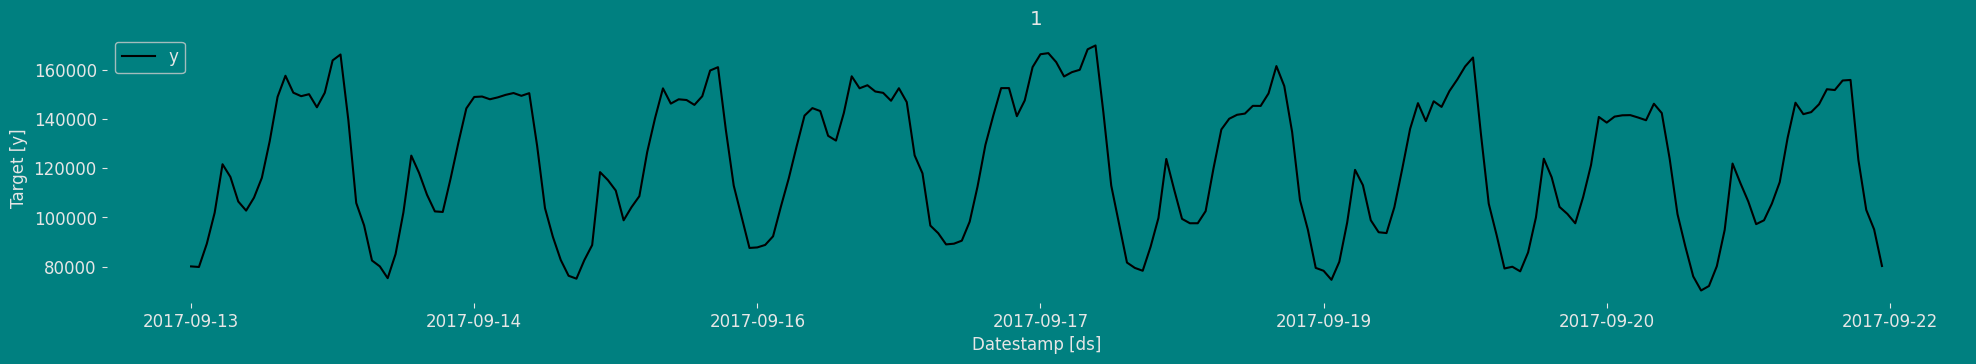

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### The Augmented Dickey-Fuller Test

An Augmented Dickey-Fuller (ADF) test is a type of statistical test that determines whether a unit root is present in time series data. Unit roots can cause unpredictable results in time series analysis. A null hypothesis is formed in the unit root test to determine how strongly time series data is affected by a trend. By accepting the null hypothesis, we accept the evidence that the time series data is not stationary. By rejecting the null hypothesis or accepting the alternative hypothesis, we accept the evidence that the time series data is generated by a stationary process. This process is also known as stationary trend. The values of the ADF test statistic are negative. Lower ADF values indicate a stronger rejection of the null hypothesis.

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

- Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend.
- Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

- ADF or t Statistic < critical values: Reject the null hypothesis, time series is stationary.
- ADF or t Statistic > critical values: Failed to reject the null hypothesis, time series is non-stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [ ]:
Augmented_Dickey_Fuller_Test_func(df["y"],'Ads')

Dickey-Fuller test results for columns: Ads
Test Statistic         -7.089634e+00
p-value                 4.444804e-10
No Lags Used            9.000000e+00
                            ...     
Critical Value (1%)    -3.462499e+00
Critical Value (5%)    -2.875675e+00
Critical Value (10%)   -2.574304e+00
Length: 7, dtype: float64
Conclusion:====>
Reject the null hypothesis
The data is stationary


### Autocorrelation plots

**Autocorrelation Function**

**Definition 1.** Let $\{x_t;1 ≤ t ≤ n\}$ be a time series sample of size n from $\{X_t\}$.
1. $\bar x = \sum_{t=1}^n \frac{x_t}{n}$ is called the sample mean of $\{X_t\}$.
2. $c_k =\sum_{t=1}^{n−k} (x_{t+k}- \bar x)(x_t−\bar x)/n$ is known as the sample autocovariance function of $\{X_t\}$.
3. $r_k = c_k /c_0$ is said to be the sample autocorrelation function of $\{X_t\}$. 

Note the following remarks about this definition:
 
* Like most literature, this guide uses ACF to denote the sample autocorrelation function as well as the autocorrelation function. What is denoted by ACF can easily be identified in context.

* Clearly c0 is the sample variance of $\{X_t\}$. Besides, $r_0 = c_0/c_0 = 1$ and for any integer $k, |r_k| ≤ 1$.

* When we compute the ACF of any sample series with a fixed length $n$, we cannot put too much confidence in the values of $r_k$ for large k’s, since fewer pairs of $(x_{t +k }, x_t )$ are available for calculating $r_k$ as $k$ is large. One rule of thumb is not to estimate $r_k$ for $k > n/3$, and another is $n ≥ 50, k ≤ n/4$. In any case, it is always a good idea to be careful.

* We also compute the ACF of a nonstationary time series sample by Definition 1. In this case, however, the ACF or $r_k$ very slowly or hardly tapers off as $k$ increases.

* Plotting the ACF $(r_k)$ against lag $k$ is easy but very helpful in analyzing time series sample. Such an ACF plot is known as a correlogram.

* If $\{X_t\}$ is stationary with $E(X_t)=0$ and $\rho_k =0$ for all $k \neq 0$,thatis,itisa white noise series, then the sampling distribution of $r_k$ is asymptotically normal with the mean 0 and the variance of $1/n$. Hence, there is about 95% chance that $r_k$ falls in the interval $[−1.96/√n, 1.96/√n]$.

Now we can give a summary that (1) if the time series plot of a time series clearly shows a trend or/and seasonality, it is surely nonstationary; (2) if the ACF $r_k$ very slowly or hardly tapers off as lag $k$ increases, the time series should also be nonstationary.

**Partial autocorrelation**

Let $\{X_t\}$ be a stationary time series with $E(X_t) = 0$. Here the assumption $E(X_t ) = 0$ is for conciseness only. If $E(X_t) = \mu \neq 0$, it is okay to replace $\{X_t\}$ by $\{X_t −\mu \}$. Now consider the linear regression (prediction) of $X_t$ on $\{X_{t−k+1:t−1}\}$ for any integer $k ≥ 2$. We use $\hat X_t$ to denote this regression (prediction):
$$\hat X_t =\alpha_1 X_{t−1}+···+\alpha_{k−1} X_{t−k+1}$$

where $\{\alpha_1, · · · , \alpha_{k−1} \}$ satisfy

$$\{\alpha_1, · · · , \alpha_{k−1} \}=\argmin_{\beta_1,···,\beta{k−1}} E[X_t −(\beta_1 X_{t−1} +···+\beta_{k−1} X_{t−k+1})]^2$$

That is, $\{\alpha_1, · · · , \alpha_{k−1} \}$ are chosen by minimizing the mean squared error of prediction. Similarly, let $\hat X_{t −k}$ denote the regression (prediction) of $X_{t −k}$ on $\{X_{t −k+1:t −1}\}$:

$$\hat X_{t−k} =\eta_1 X_{t−1}+···+\eta_{k−1} X_{t−k+1} $$

Note that if $\{X_t\}$ is stationary, then $\{\alpha_{1:k−1} \} = \{\eta_{1:k−1} \}$. Now let $\hat Z_{t−k} = X_{t−k} − \hat X_{t−k}$ and $\hat Z_t = X_t − \hat X_t$. Then $\hat Z_{t−k}$ is the residual of removing the effect of the intervening variables $\{X_{t−k+1:t−1} \}$ from $X_{t−k}$, and $\hat Z_t$ is the residual of removing the effect of $\{X_{t −k+1:t −1} \}$ from $X_t$ .

**Definition 2.**  The partial autocorrelation function (PACF) at lag $k$ of a stationary time series $\{X_t \}$ with $E(X_t ) = 0$ is

$$\phi_{11} = Corr(X_{t−1}, X_t ) = \frac{Cov(X_{t−1}, X_t )} {[Var(X_{t−1})Var(X_t)]^{1/2}} = \rho_1$$
and

$$\phi_{kk} = Corr(\hat Z_{t−k},\hat Z_t) = \frac{Cov(\hat Z_{t−k},\hat Z_t)} {[Var(\hat Z_{t −k} )Var(\hat Z_t )]^{1/2}}, \ k ≥ 2  $$

On the other hand, the following theorem paves the way to estimate the PACF of a stationary time series, and its proof can be seen in Fan and Yao (2003).

**Theorem 1.** Let $\{X_t \}$ be a stationary time series with $E(X_t ) = 0$, and $\{a_{1k},··· ,a_{kk}\}$ satisfy

$$\{a_{1k},··· ,a_{kk}\}= \argmin_{a_1 ,··· ,a_k}  E(X_t − a_1 X_{t−1}−···−a_k X_{t−k})^2 $$

Then $\phi_{kk} =a_{kk}$ for $k≥1$.

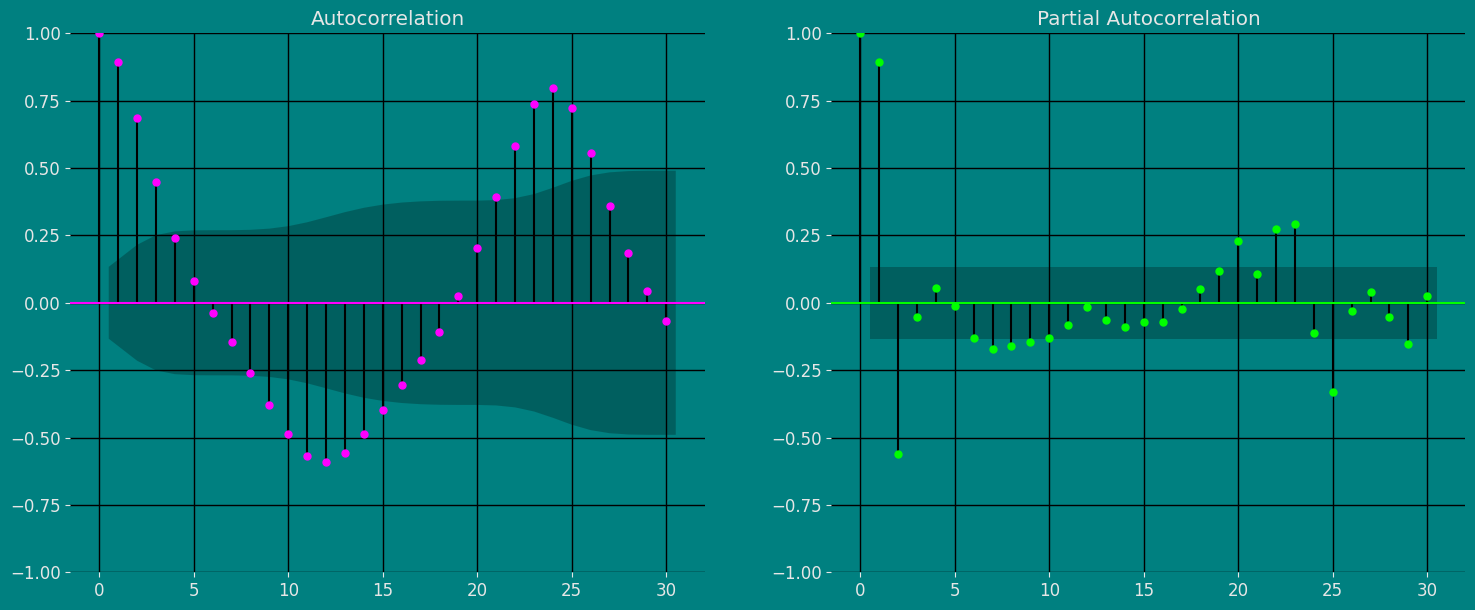

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show();

### Decomposition of the time series

How to decompose a time series and why?

In time series analysis to forecast new values, it is very important to know past data. More formally, we can say that it is very important to know the patterns that values follow over time. There can be many reasons that cause our forecast values to fall in the wrong direction. Basically, a time series consists of four components. The variation of those components causes the change in the pattern of the time series. These components are:

* **Level:** This is the primary value that averages over time.
* **Trend:** The trend is the value that causes increasing or decreasing patterns in a time series.
* **Seasonality:** This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
* **Residual/Noise:** These are the random variations in the time series.

Combining these components over time leads to the formation of a time series. Most time series consist of level and noise/residual and trend or seasonality are optional values.

If seasonality and trend are part of the time series, then there will be effects on the forecast value. As the pattern of the forecasted time series may be different from the previous time series.

The combination of the components in time series can be of two types:
* Additive
* Multiplicative

### Additive time series

If the components of the time series are added to make the time series. Then the time series is called the additive time series. By visualization, we can say that the time series is additive if the increasing or decreasing pattern of the time series is similar throughout the series. The mathematical function of any additive time series can be represented by:
$$y(t) = level + Trend + seasonality + noise$$

### Multiplicative time series

If the components of the time series are multiplicative together, then the time series is called a multiplicative time series. For visualization, if the time series is having exponential growth or decline with time, then the time series can be considered as the multiplicative time series. The mathematical function of the multiplicative time series can be represented as.

$$y(t) = Level * Trend * seasonality * Noise$$

### Additive

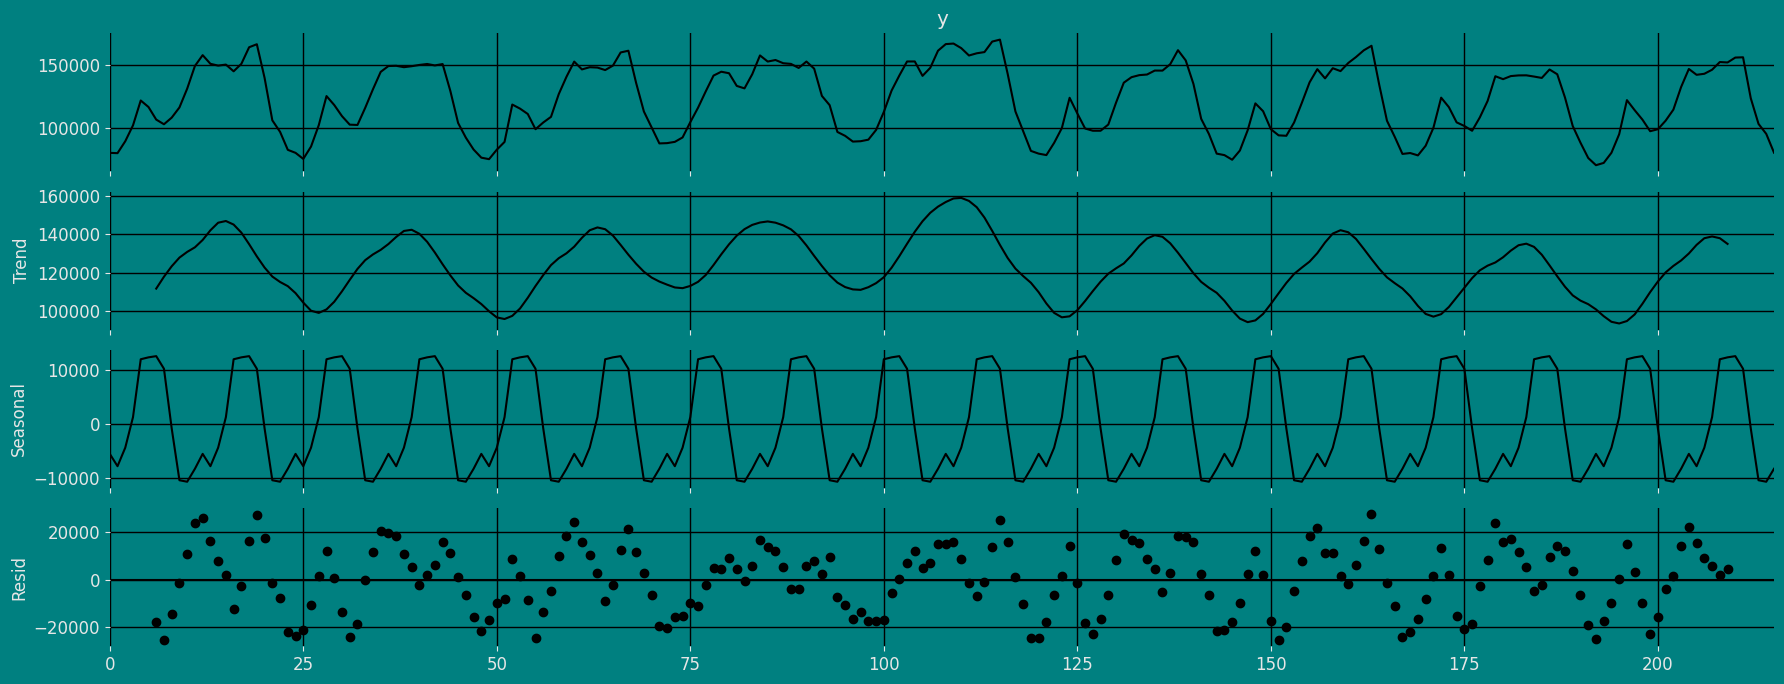

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "additive", period=12)
a.plot();

### Multiplicative

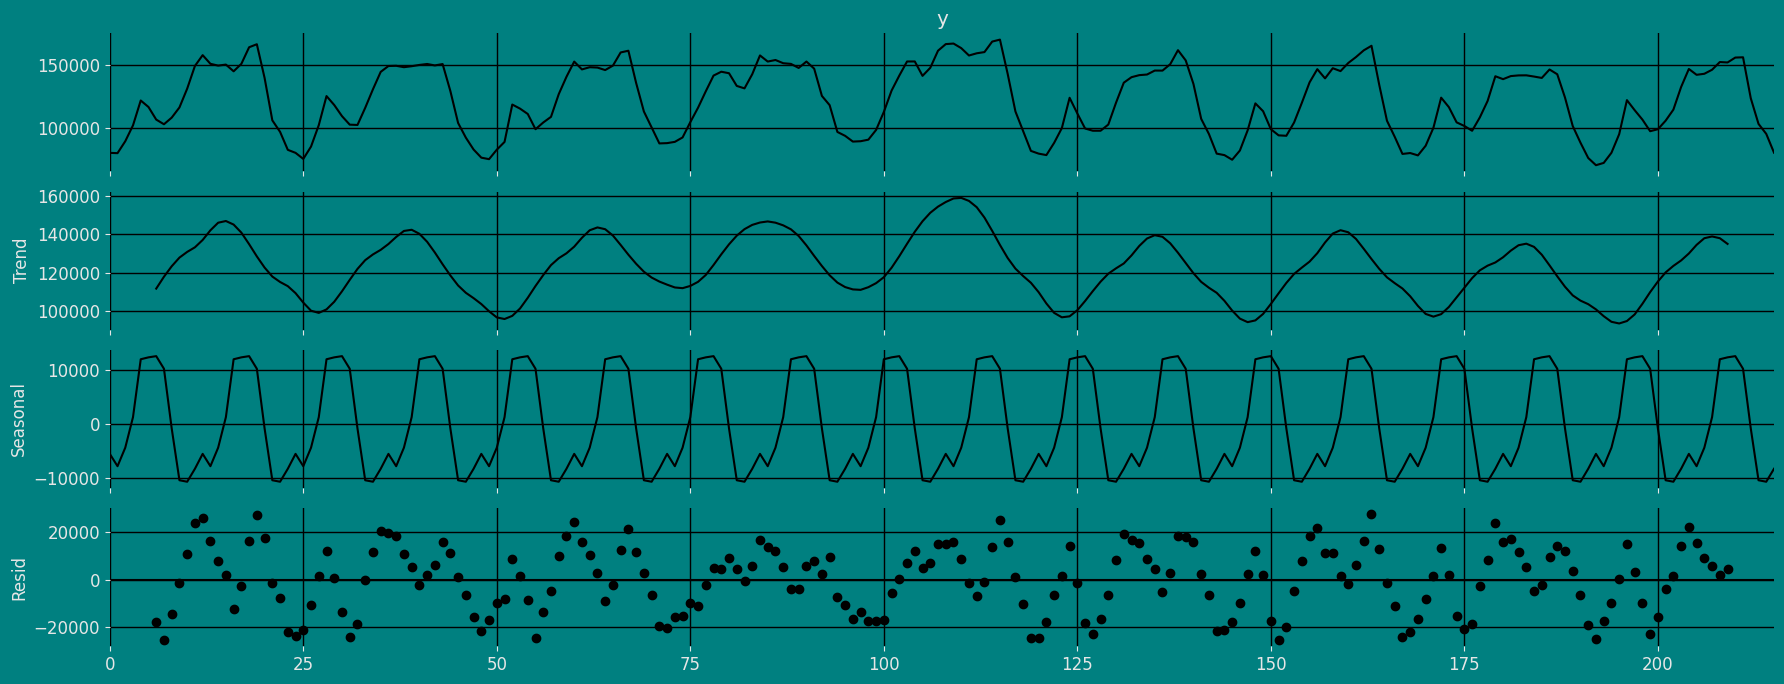

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose 
a = seasonal_decompose(df["y"], model = "Multiplicative", period=12)
a.plot();

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets
1. Data to train our `Holt Model`.
2. Data to test our model

For the test data we will use the last 30 hours to test and evaluate the performance of our model.

In [ ]:
train = df[df.ds<='2017-09-20 17:00:00'] 
test = df[df.ds>'2017-09-20 17:00:00'] 

In [ ]:
train.shape, test.shape

((186, 3), (30, 3))

Now let's plot the training data and the test data.

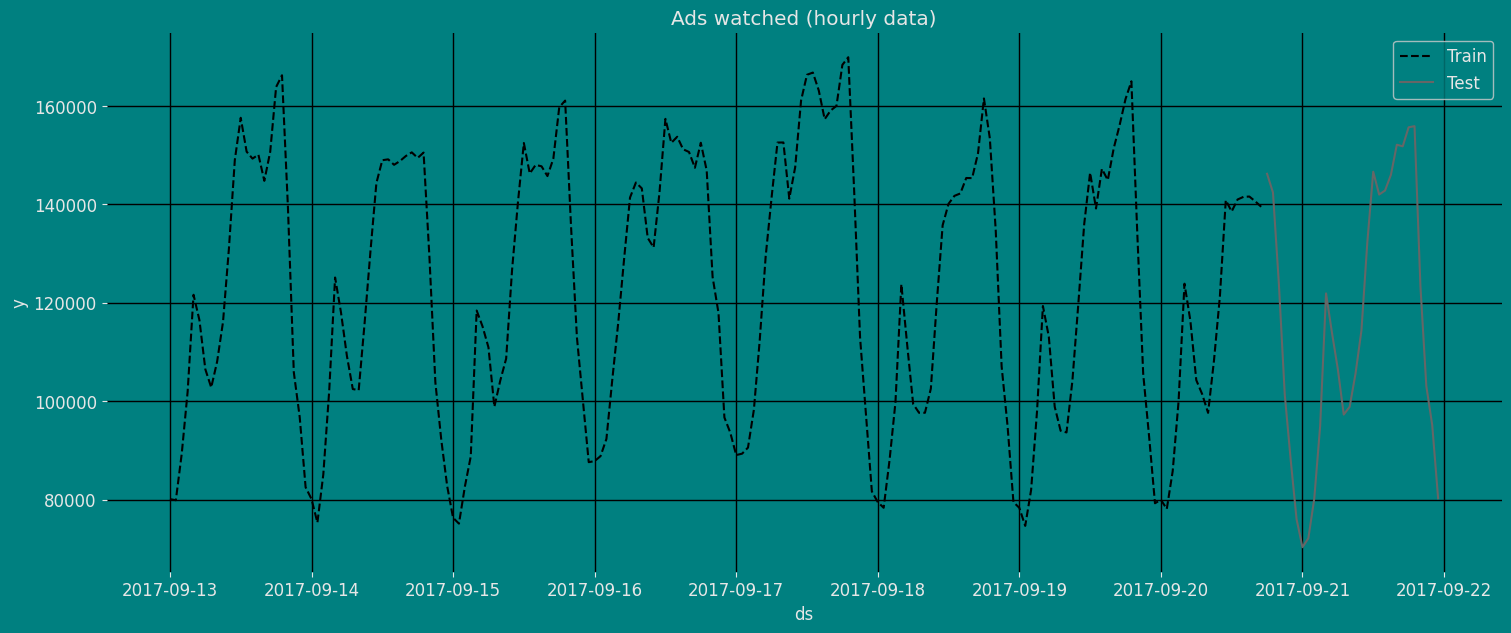

In [ ]:
sns.lineplot(train,x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.title("Ads watched (hourly data)");
plt.show()

## Implementation of Holt Method with StatsForecast <a class="anchor" id="implementation"></a>

To also know more about the parameters of the functions of the `Holt Model`, they are listed below. For more information, visit the [documentation](https://nixtla.github.io/statsforecast/src/core/models.html#holts-method).

```
season_length : int
    Number of observations per unit of time. Ex: 12 Monthly data.
error_type : str
    The type of error of the ETS model. Can be additive (A) or multiplicative (M).
alias : str
    Custom name of the model.
prediction_intervals : Optional[ConformalIntervals]
    Information to compute conformal prediction intervals.
    By default, the model will compute the native prediction
    intervals.
```

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import Holt

### Instantiate Model

Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by the master, Rob Hyndmann, can be useful for `season_length`.


In [ ]:
season_length = 24 # Hourly data 
horizon = len(test) # number of predictions

models = [Holt(season_length=season_length, error_type="A", alias="Add"),
          Holt(season_length=season_length, error_type="M", alias="Multi")]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [pandas’ available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(df=df,
                   models=models,
                   freq='H', 
                   n_jobs=-1)

### Fit the Model

In [ ]:
sf.fit()

StatsForecast(models=[Add,Multi])

Let's see the results of our `Holt Model`. We can observe it with the following instruction:

In [ ]:
result=sf.fitted_[0,0].model_
result

{'loglik': -2606.8868945585214,
 'aic': 5223.773789117043,
 'bic': 5240.6501811554635,
 'aicc': 5224.059503402757,
 'mse': 140759484.56327003,
 'amse': 455398067.7328947,
 'fit': results(x=array([ 9.99900000e-01,  1.00000000e-04,  7.99488495e+04, -4.74727943e+00]), fn=5213.773789117043, nit=72, simplex=array([[ 9.99900000e-01,  1.00000000e-04,  7.99083958e+04,
          3.48822281e+00],
        [ 9.99900000e-01,  1.00000000e-04,  7.99488495e+04,
         -4.74727943e+00],
        [ 9.99900000e-01,  1.00000000e-04,  8.02890214e+04,
          7.41636110e+00],
        [ 9.99900000e-01,  1.00000000e-04,  8.01679532e+04,
         -1.60232330e+01],
        [ 9.99900000e-01,  1.00000000e-04,  8.03170190e+04,
         -3.36503173e+00]])),
 'residuals': array([ 1.70897743e+02, -2.25252721e+02,  9.44473019e+03,  1.26097527e+04,
         1.97038082e+04, -5.15245273e+03, -9.97942311e+03, -3.69890787e+03,
         5.26209007e+03,  8.07245996e+03,  1.49069338e+04,  1.79911265e+04,
         8.5696358

Let us now visualize the fitted values of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [ ]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,170.897743
1,-225.252721
2,9444.730190
...,...
213,-20317.858920
214,-7924.609136
215,-14867.577350


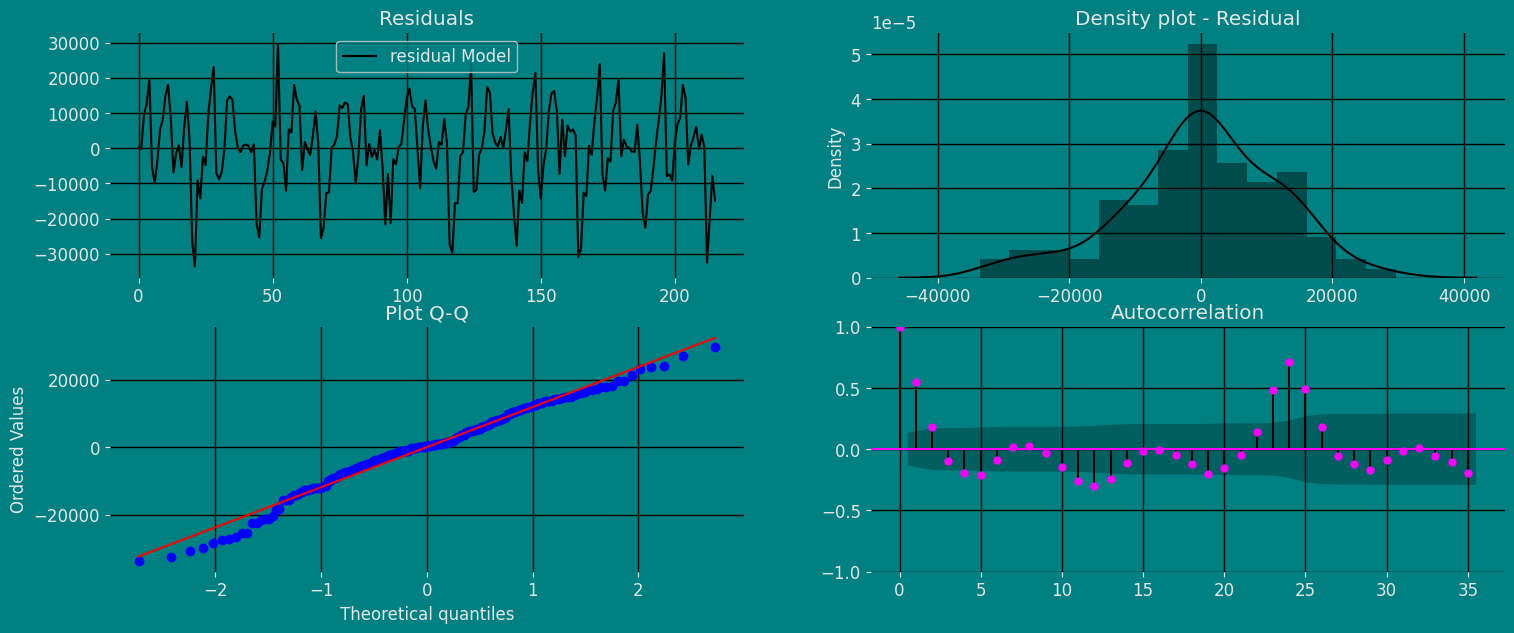

In [ ]:
import scipy.stats as stats

fig, axs = plt.subplots(nrows=2, ncols=2)

residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min.

In [ ]:
Y_hat = sf.forecast(horizon, fitted=True)
Y_hat

,ds,Add,Multi
unique_id,,,
1,2017-09-22 00:00:00,80281.781250,81537.476562
1,2017-09-22 01:00:00,80277.085938,82788.335938
1,2017-09-22 02:00:00,80272.382812,84039.195312
...,...,...,...
1,2017-09-23 03:00:00,80154.835938,115310.718750
1,2017-09-23 04:00:00,80150.132812,116561.578125
1,2017-09-23 05:00:00,80145.429688,117812.437500


In [ ]:
values=sf.forecast_fitted_values()
values.head()

,ds,y,Add,Multi
unique_id,,,,
1,2017-09-13 00:00:00,80115.0,79944.101562,79406.656250
1,2017-09-13 01:00:00,79885.0,80110.250000,81393.054688
1,2017-09-13 02:00:00,89325.0,79880.273438,81163.125000
1,2017-09-13 03:00:00,101930.0,89320.250000,90602.976562
1,2017-09-13 04:00:00,121630.0,101926.195312,103208.789062


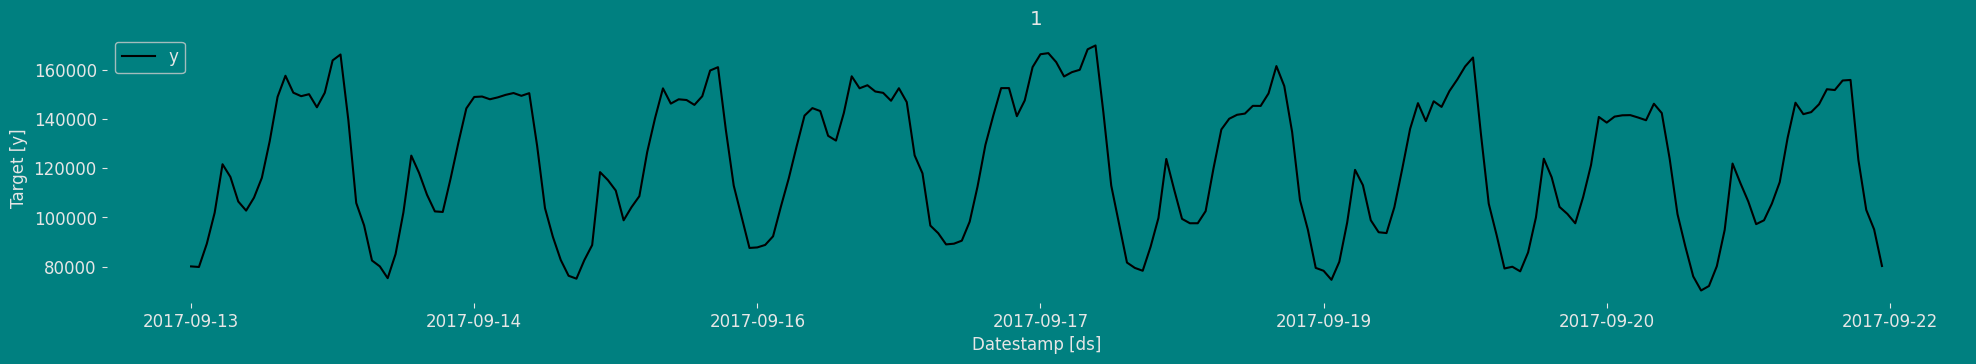

In [ ]:
StatsForecast.plot(values)

Adding 95% confidence interval with the forecast method

In [ ]:
sf.forecast(h=horizon, level=[95])

,ds,Add,Add-lo-95,Add-hi-95,Multi,Multi-lo-95,Multi-hi-95
unique_id,,,,,,,
1,2017-09-22 00:00:00,80281.781250,56698.507812,103865.062500,81537.476562,65208.687500,97866.257812
1,2017-09-22 01:00:00,80277.085938,46925.292969,113628.875000,82788.335938,59458.406250,106118.265625
1,2017-09-22 02:00:00,80272.382812,39423.585938,121121.179688,84039.195312,55172.894531,112905.500000
...,...,...,...,...,...,...,...
1,2017-09-23 03:00:00,80154.835938,-44792.613281,205102.281250,115310.718750,3485.836914,227135.593750
1,2017-09-23 04:00:00,80150.132812,-47015.281250,207315.546875,116561.578125,1745.947998,231377.203125
1,2017-09-23 05:00:00,80145.429688,-49200.355469,209491.218750,117812.437500,1.485114,235623.390625


In [ ]:
Y_hat=Y_hat.reset_index()
Y_hat

,unique_id,ds,Add,Multi
0,1,2017-09-22 00:00:00,80281.781250,81537.476562
1,1,2017-09-22 01:00:00,80277.085938,82788.335938
2,1,2017-09-22 02:00:00,80272.382812,84039.195312
...,...,...,...,...
27,1,2017-09-23 03:00:00,80154.835938,115310.718750
28,1,2017-09-23 04:00:00,80150.132812,116561.578125
29,1,2017-09-23 05:00:00,80145.429688,117812.437500


In [ ]:
# Merge the forecasts with the true values
Y_hat1 = pd.concat([df,Y_hat],  keys=['unique_id', 'ds'])
Y_hat1

ds        y  unique_id           Add  \
unique_id 0  2017-09-13 00:00:00  80115.0          1           NaN   
          1  2017-09-13 01:00:00  79885.0          1           NaN   
          2  2017-09-13 02:00:00  89325.0          1           NaN   
...                          ...      ...        ...           ...   
ds        27 2017-09-23 03:00:00      NaN          1  80154.835938   
          28 2017-09-23 04:00:00      NaN          1  80150.132812   
          29 2017-09-23 05:00:00      NaN          1  80145.429688   

                      Multi  
unique_id 0             NaN  
          1             NaN  
          2             NaN  
...                     ...  
ds        27  115310.718750  
          28  116561.578125  
          29  117812.437500  

[246 rows x 5 columns]

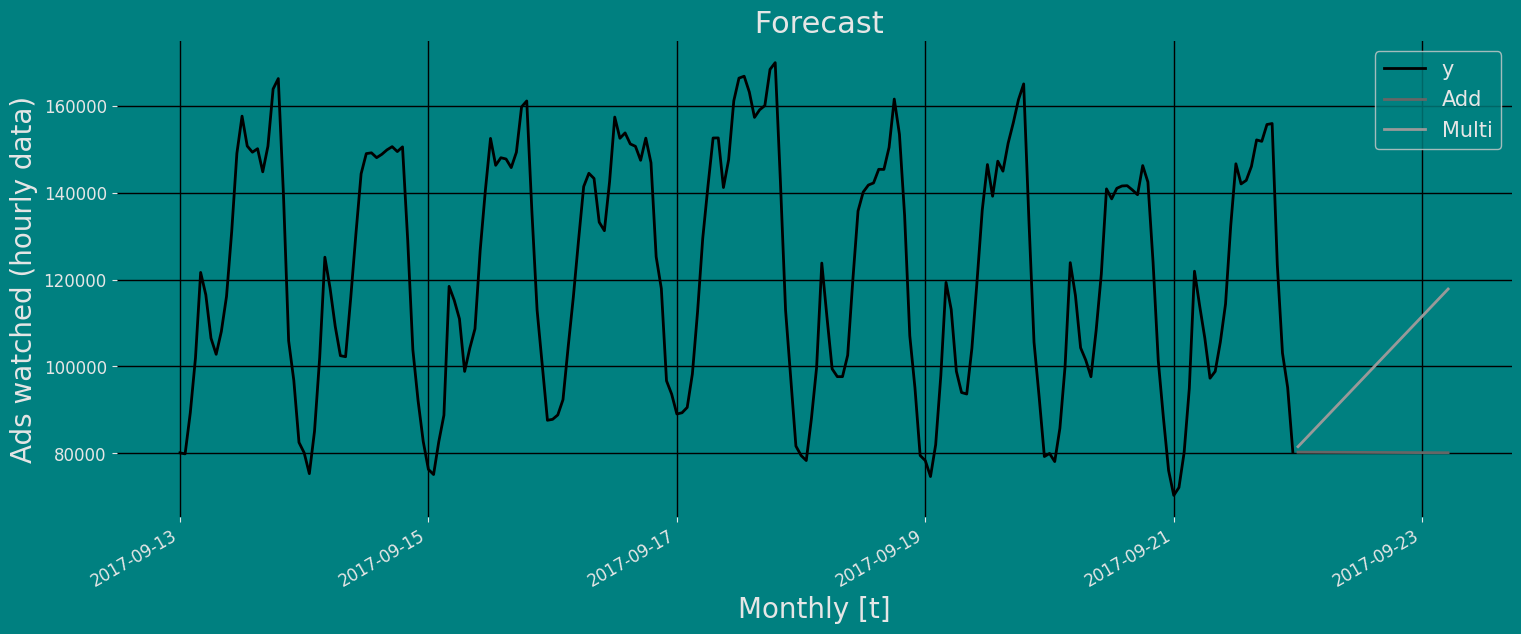

In [ ]:
fig, ax = plt.subplots(1, 1)
plot_df = pd.concat([train, Y_hat1]).set_index('ds').tail(300)
plot_df['y'].plot(ax=ax, linewidth=2)
plot_df[ "Add"].plot(ax=ax, linewidth=2)
plot_df[ "Multi"].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Ads watched (hourly data)', fontsize=20)
ax.set_xlabel('Monthly [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid(True)


### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[95]` means that the model expects the real value to be inside that interval 95% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
sf.predict(h=horizon)

,ds,Add,Multi
unique_id,,,
1,2017-09-22 00:00:00,80281.781250,81537.476562
1,2017-09-22 01:00:00,80277.085938,82788.335938
1,2017-09-22 02:00:00,80272.382812,84039.195312
...,...,...,...
1,2017-09-23 03:00:00,80154.835938,115310.718750
1,2017-09-23 04:00:00,80150.132812,116561.578125
1,2017-09-23 05:00:00,80145.429688,117812.437500


In [ ]:
forecast_df = sf.predict(h=horizon, level=[80,95]) 

forecast_df

,ds,Add,Add-lo-95,Add-lo-80,Add-hi-80,Add-hi-95,Multi,Multi-lo-95,Multi-lo-80,Multi-hi-80,Multi-hi-95
unique_id,,,,,,,,,,,
1,2017-09-22 00:00:00,80281.781250,56698.507812,64861.507812,95702.062500,103865.062500,81537.476562,65208.687500,70860.656250,92214.289062,97866.257812
1,2017-09-22 01:00:00,80277.085938,46925.292969,58469.519531,102084.648438,113628.875000,82788.335938,59458.406250,67533.710938,98042.953125,106118.265625
1,2017-09-22 02:00:00,80272.382812,39423.585938,53562.789062,106981.976562,121121.179688,84039.195312,55172.894531,65164.535156,102913.851562,112905.500000
...,...,...,...,...,...,...,...,...,...,...,...
1,2017-09-23 03:00:00,80154.835938,-44792.613281,-1543.909790,161853.578125,205102.281250,115310.718750,3485.836914,42192.359375,188429.078125,227135.593750
1,2017-09-23 04:00:00,80150.132812,-47015.281250,-2998.863037,163299.125000,207315.546875,116561.578125,1745.947998,41487.671875,191635.484375,231377.203125
1,2017-09-23 05:00:00,80145.429688,-49200.355469,-4429.233887,164720.093750,209491.218750,117812.437500,1.485114,40779.996094,194844.875000,235623.390625


We can join the forecast result with the historical data using the pandas function `pd.concat()`, and then be able to use this result for graphing.

In [ ]:
pd.concat([df, forecast_df]).set_index('ds')

,y,unique_id,Add,Add-lo-95,Add-lo-80,Add-hi-80,Add-hi-95,Multi,Multi-lo-95,Multi-lo-80,Multi-hi-80,Multi-hi-95
ds,,,,,,,,,,,,
2017-09-13 00:00:00,80115.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 01:00:00,79885.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 02:00:00,89325.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-23 03:00:00,NaN,NaN,80154.835938,-44792.613281,-1543.909790,161853.578125,205102.281250,115310.718750,3485.836914,42192.359375,188429.078125,227135.593750
2017-09-23 04:00:00,NaN,NaN,80150.132812,-47015.281250,-2998.863037,163299.125000,207315.546875,116561.578125,1745.947998,41487.671875,191635.484375,231377.203125
2017-09-23 05:00:00,NaN,NaN,80145.429688,-49200.355469,-4429.233887,164720.093750,209491.218750,117812.437500,1.485114,40779.996094,194844.875000,235623.390625


In [ ]:
df_plot= pd.concat([df, forecast_df]).set_index('ds')
df_plot

,y,unique_id,Add,Add-lo-95,Add-lo-80,Add-hi-80,Add-hi-95,Multi,Multi-lo-95,Multi-lo-80,Multi-hi-80,Multi-hi-95
ds,,,,,,,,,,,,
2017-09-13 00:00:00,80115.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 01:00:00,79885.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 02:00:00,89325.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-23 03:00:00,NaN,NaN,80154.835938,-44792.613281,-1543.909790,161853.578125,205102.281250,115310.718750,3485.836914,42192.359375,188429.078125,227135.593750
2017-09-23 04:00:00,NaN,NaN,80150.132812,-47015.281250,-2998.863037,163299.125000,207315.546875,116561.578125,1745.947998,41487.671875,191635.484375,231377.203125
2017-09-23 05:00:00,NaN,NaN,80145.429688,-49200.355469,-4429.233887,164720.093750,209491.218750,117812.437500,1.485114,40779.996094,194844.875000,235623.390625


Now let's visualize the result of our forecast and the historical data of our time series, also let's draw the confidence interval that we have obtained when making the prediction with 95% confidence.

In [ ]:
def plot_forecasts(y_hist, y_pred, models):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    df_plot = pd.concat([y_hist, y_pred]).set_index('ds').tail(12*10)
    df_plot[['y'] + models].plot(ax=ax, linewidth=3 , )
    colors = ['green', "lime"]
    ax.fill_between(df_plot.index, 
                df_plot['Add-lo-80'], 
                df_plot['Add-hi-80'],
                alpha=.20,
                color='fuchsia',
                label='Holt_level_80')
    ax.fill_between(df_plot.index, 
                df_plot['Add-lo-95'], 
                df_plot['Add-hi-95'],
                alpha=.3,
                color='lime',
                label='Holt_level_95')
    ax.set_title('', fontsize=22)
    ax.set_ylabel("Ads watched (hourly data)", fontsize=20)
    ax.set_xlabel('Hourly', fontsize=20)
    ax.legend(prop={'size': 20})
    ax.grid(True)
    plt.show()

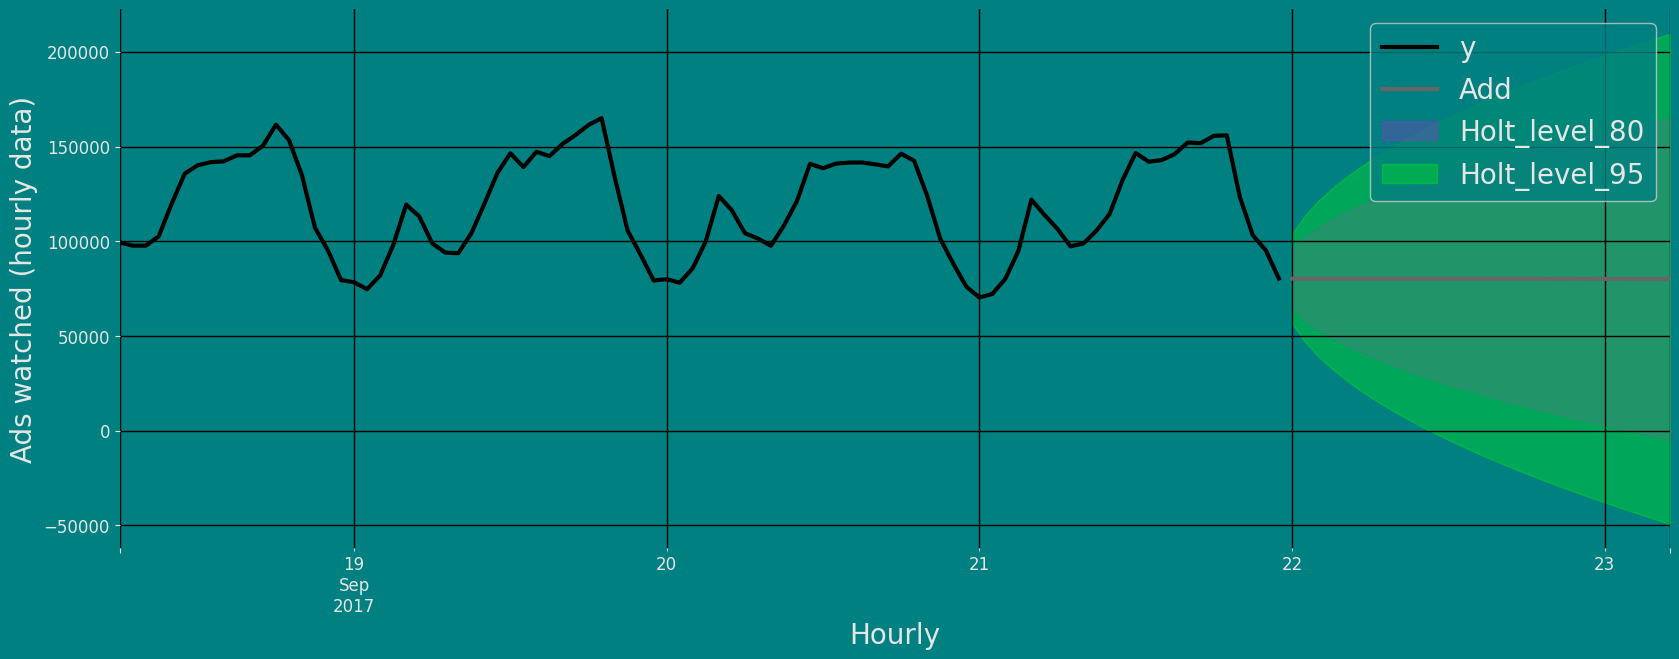

In [ ]:
plot_forecasts(df, forecast_df, models=["Add"])

Let's plot the same graph using the plot function that comes in `Statsforecast`, as shown below.

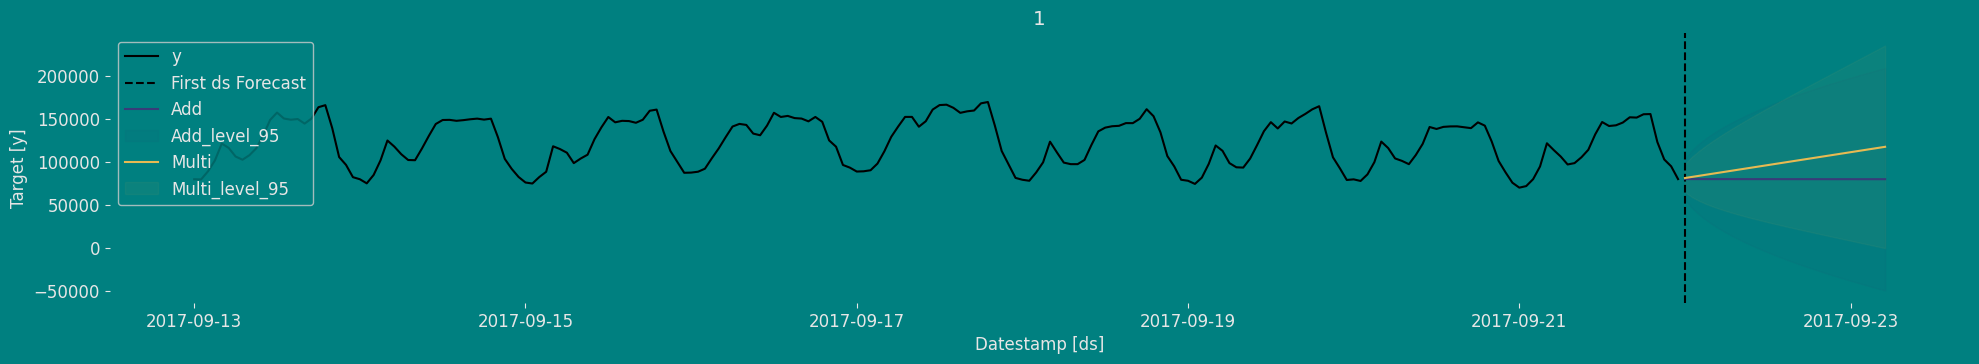

In [ ]:
sf.plot(df, forecast_df)

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=)`, forecasting every second months `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 30 hours ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=df,
                                         h=horizon,
                                         step_size=30,
                                         n_windows=3)

The crossvaldation_df object is a new data frame that includes the following columns:

* `unique_id:` index. If you dont like working with index just run `crossvalidation_df.resetindex()`.
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the `n_windows`.
* `y:` true value
* `model:` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df

,ds,cutoff,y,Add,Multi
unique_id,,,,,
1,2017-09-18 06:00:00,2017-09-18 05:00:00,99440.0,111573.328125,112901.664062
1,2017-09-18 07:00:00,2017-09-18 05:00:00,97655.0,111820.390625,114476.921875
1,2017-09-18 08:00:00,2017-09-18 05:00:00,97655.0,112067.453125,116052.179688
...,...,...,...,...,...
1,2017-09-21 21:00:00,2017-09-20 17:00:00,103080.0,148230.671875,183085.953125
1,2017-09-21 22:00:00,2017-09-20 17:00:00,95155.0,148541.937500,184642.046875
1,2017-09-21 23:00:00,2017-09-20 17:00:00,80285.0,148853.203125,186198.140625


## Model Evaluation <a class="anchor" id="evaluate"></a>

We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we’ll use the Root Mean Squared Error (RMSE). To do this, we first need to `install datasetsforecast`, a Python library developed **by Nixtla** that includes a function to compute the RMSE.

In [ ]:
%%capture
!pip install datasetsforecast

The function to compute the RMSE takes two arguments:

1. The actual values.
2. The forecasts, in this case, `Holt Model`.

In [ ]:
from datasetsforecast.losses import rmse

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for model in models:
        eval_ = df.groupby(['unique_id', 'cutoff']).apply(lambda x: metric(x['y'].values, x[model].values)).to_frame() # Calculate loss for every unique_id, model and cutoff.
        eval_.columns = [model]
        evals.append(eval_)
    evals = pd.concat(evals, axis=1)
    evals = evals.groupby(['unique_id']).mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

In [ ]:
evaluation_df = evaluate_cross_validation(crossvalidation_df, rmse)
evaluation_df

,Add,Multi,best_model
unique_id,,,
1,31882.099609,46589.265625,Add


## Acknowledgements

We would like to thank [Naren Castellon](https://www.linkedin.com/in/naren-castellon-1541b8101/?originalSubdomain=pa) for writing this tutorial.

## References <a class="anchor" id="references"></a>

1. Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python. 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla Parameters](https://nixtla.github.io/statsforecast/src/core/models.html#arch-model).
5. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
6. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html).
7. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).